In [1]:
import os 
os.chdir("/home/pipegalera/dev/energy_forecasting/src")
os.getcwd()

'/home/pipegalera/dev/energy_forecasting/src'

In [2]:
from dotenv import load_dotenv
load_dotenv()
import sys
import os
import datetime
from utils import complete_timeframe, create_group_lags, create_group_rolling_means, create_date_colunms,create_horizon_dates
import pandas as pd
import xgboost as xgb
import argparse
import numpy as np
import mlflow
import json

mlflow.set_tracking_uri(f"sqlite:///mlflow/mlflow.db")
DATA_PATH = os.getenv("DATA_PATH")
MODELS_PATH = os.getenv("MODELS_PATH")

# Load RUN IDs from MLflow
with open(f"{MODELS_PATH}/run_id_mapping.json", "r") as f:
    run_id_mapping = json.load(f)

covs = ['value_lag_3', 'value_lag_6', 'value_lag_12',
       'value_lag_24', 'value_lag_48', 'value_lag_168', 'value_lag_336',
       'value_lag_720', 'value_lag_2160', 'value_rolling_mean_3_hours',
       'value_rolling_mean_6_hours', 'value_rolling_mean_12_hours',
       'value_rolling_mean_24_hours', 'value_rolling_mean_48_hours',
       'value_rolling_mean_168_hours', 'value_rolling_mean_336_hours',
       'value_rolling_mean_720_hours', 'value_rolling_mean_2160_hours',
       'period_hour', 'period_day', 'period_week', 'period_year',
       'period_day_of_week', 'period_day_of_year', 'period_month_end',
       'period_month_start', 'period_quarter_end', 'period_quarter_start',
       'period_year_end', 'period_year_start']

In [3]:

def make_predictions(data, covs = covs):

    df = data.copy()

    predictions = []
    subbas = df["subba"].unique()

    for subba in subbas:

        df_subba = df[df["subba"] == subba][covs]

        # Load model
        run_id = run_id_mapping.get(subba)
        model_uri = f"runs:/{run_id}/xgboost_model_{subba}"
        model = mlflow.xgboost.load_model(model_uri)

        prediction = model.predict(df_subba)
        predictions.extend(prediction)

    df["forecasted_value"] = predictions
    df["forecasted_value"] = df["forecasted_value"].astype('int32')

    df.drop(covs, axis=1, inplace=True)

    return df

In [4]:
df = pd.read_parquet(f"{DATA_PATH}/data.parquet")
create_horizon_dates(df, "subba", 1).tail(28)

,period,subba,subba-name,parent,parent-name,value,value-units
203237,2024-10-20 04:00:00+00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,58.0,megawatthours
203238,2024-10-20 05:00:00+00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,56.0,megawatthours
203239,2024-10-20 06:00:00+00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,52.0,megawatthours
203240,2024-10-20 07:00:00+00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,49.0,megawatthours
0,2024-10-20 08:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN
1,2024-10-20 09:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN
2,2024-10-20 10:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN
3,2024-10-20 11:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN
4,2024-10-20 12:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN
5,2024-10-20 13:00:00+00:00,VEA,NaN,NaN,NaN,NaN,NaN


In [5]:
df = pd.read_parquet(f"{DATA_PATH}/data.parquet")

In [6]:

# PREP DATA
#print(f"--> Creating new forecasts...")
df_horizon = (df
                .pipe(complete_timeframe, bfill=True)
                .pipe(create_horizon_dates, 'subba', days_after=1)
                .pipe(create_group_lags, 'subba', ['value'], lags=[3,6,12,24,48,168,336,720,2160])
                .pipe(create_group_rolling_means, 'subba', ['value'], windows=[3,6,12,24,48,168,336,720,2160])
                .pipe(create_date_colunms, 'period')
     )
df_horizon = df_horizon.sort_values(['subba', 'period'])

df_horizon

#df_horizon.period.max()

,period,subba,subba-name,parent,parent-name,value,value-units,value_lag_3_hours,value_lag_6_hours,value_lag_12_hours,...,period_week,period_year,period_day_of_week,period_day_of_year,period_month_end,period_month_start,period_quarter_end,period_quarter_start,period_year_end,period_year_start
0,2019-01-01 01:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11256.0,megawatthours,NaN,NaN,NaN,...,1,2019,1,1,False,True,False,True,False,True
38166,2019-01-01 02:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,12501.0,megawatthours,NaN,NaN,NaN,...,1,2019,1,1,False,True,False,True,False,True
33918,2019-01-01 03:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,12513.0,megawatthours,NaN,NaN,NaN,...,1,2019,1,1,False,True,False,True,False,True
33919,2019-01-01 04:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,12094.0,megawatthours,11256.0,NaN,NaN,...,1,2019,1,1,False,True,False,True,False,True
33920,2019-01-01 05:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11604.0,megawatthours,12501.0,NaN,NaN,...,1,2019,1,1,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169622,2024-10-21 03:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,2024,0,295,False,False,False,False,False,False
169623,2024-10-21 04:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,2024,0,295,False,False,False,False,False,False
165380,2024-10-21 05:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,2024,0,295,False,False,False,False,False,False
186577,2024-10-21 06:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,2024,0,295,False,False,False,False,False,False


In [7]:
df_horizon.tail(28)

,period,subba,subba-name,parent,parent-name,value,value-units,value_lag_3_hours,value_lag_6_hours,value_lag_12_hours,...,period_week,period_year,period_day_of_week,period_day_of_year,period_month_end,period_month_start,period_quarter_end,period_quarter_start,period_year_end,period_year_start
169649,2024-10-20 04:00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,58.0,megawatthours,71.0,100.0,58.0,...,42,2024,6,294,False,False,False,False,False,False
169628,2024-10-20 05:00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,56.0,megawatthours,57.0,74.0,122.0,...,42,2024,6,294,False,False,False,False,False,False
169650,2024-10-20 06:00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,52.0,megawatthours,59.0,63.0,162.0,...,42,2024,6,294,False,False,False,False,False,False
169627,2024-10-20 07:00:00,VEA,Valley Electric Association - CISO,CISO,California Independent System Operator,49.0,megawatthours,58.0,71.0,159.0,...,42,2024,6,294,False,False,False,False,False,False
169625,2024-10-20 08:00:00,VEA,NaN,NaN,NaN,NaN,NaN,56.0,57.0,183.0,...,42,2024,6,294,False,False,False,False,False,False
169604,2024-10-20 09:00:00,VEA,NaN,NaN,NaN,NaN,NaN,52.0,59.0,185.0,...,42,2024,6,294,False,False,False,False,False,False
169605,2024-10-20 10:00:00,VEA,NaN,NaN,NaN,NaN,NaN,49.0,58.0,100.0,...,42,2024,6,294,False,False,False,False,False,False
169606,2024-10-20 11:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,56.0,74.0,...,42,2024,6,294,False,False,False,False,False,False
169607,2024-10-20 12:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,52.0,63.0,...,42,2024,6,294,False,False,False,False,False,False
169608,2024-10-20 13:00:00,VEA,NaN,NaN,NaN,NaN,NaN,NaN,49.0,71.0,...,42,2024,6,294,False,False,False,False,False,False


In [ ]:
10-20

In [72]:
df = pd.read_parquet("/Users/pipegalera/dev/Documents/GitHub/energy_forecasting/data/inference.parquet")

In [73]:
df

,period,subba,value,forecasted_value
0,2024-10-16 07:00:00+00:00,PGAE,11960.0,NaN
1,2024-10-16 08:00:00+00:00,PGAE,11297.0,NaN
2,2024-10-16 09:00:00+00:00,PGAE,10924.0,NaN
3,2024-10-16 10:00:00+00:00,PGAE,10344.0,NaN
4,2024-10-16 11:00:00+00:00,PGAE,10005.0,NaN
...,...,...,...,...
575,2024-10-22 03:00:00+00:00,VEA,NaN,59.0
576,2024-10-22 04:00:00+00:00,VEA,NaN,57.0
577,2024-10-22 05:00:00+00:00,VEA,NaN,51.0
578,2024-10-22 06:00:00+00:00,VEA,NaN,46.0


In [17]:
df[df["period"]>"2024"]

,period,subba,subba-name,parent,parent-name,value,value-units,value_lag_3,value_lag_6,value_lag_12,...,period_year,period_day_of_week,period_day_of_year,period_month_end,period_month_start,period_quarter_end,period_quarter_start,period_year_end,period_year_start,forecasted_value
43824,2024-01-01 01:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,9378.483398,megawatthours,10121.0,10387.0,9090.0,...,2024.0,0.0,1.0,False,True,False,True,False,True,NaN
43825,2024-01-01 02:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,10579.226562,megawatthours,10151.0,10192.0,9076.0,...,2024.0,0.0,1.0,False,True,False,True,False,True,NaN
43826,2024-01-01 03:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11176.168945,megawatthours,10292.0,10306.0,9308.0,...,2024.0,0.0,1.0,False,True,False,True,False,True,NaN
43827,2024-01-01 04:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11442.276367,megawatthours,10687.0,10121.0,9593.0,...,2024.0,0.0,1.0,False,True,False,True,False,True,NaN
43828,2024-01-01 05:00:00,PGAE,Pacific Gas and Electric,CISO,California Independent System Operator,11340.517578,megawatthours,11251.0,10151.0,9903.0,...,2024.0,0.0,1.0,False,True,False,True,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203600,2024-10-24 06:00:00,VEA,None,None,None,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,48.0
203601,2024-10-24 07:00:00,PGAE,None,None,None,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,11112.0
203602,2024-10-24 07:00:00,SCE,None,None,None,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,12219.0
203603,2024-10-24 07:00:00,SDGE,None,None,None,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,2319.0


subba
PGAE    Axes(0.125,0.2;0.775x0.68)
SCE     Axes(0.125,0.2;0.775x0.68)
SDGE    Axes(0.125,0.2;0.775x0.68)
VEA     Axes(0.125,0.2;0.775x0.68)
dtype: object

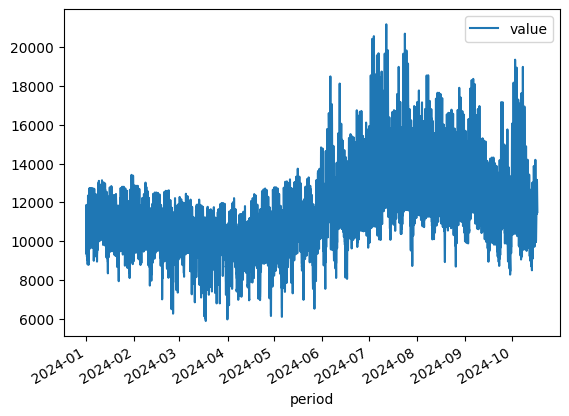

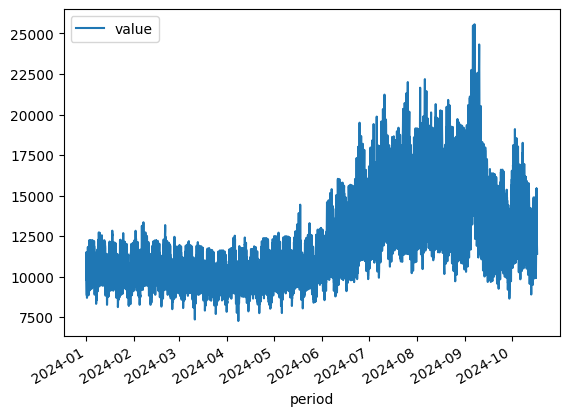

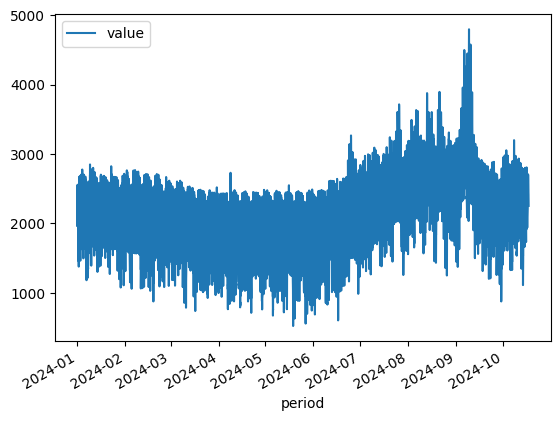

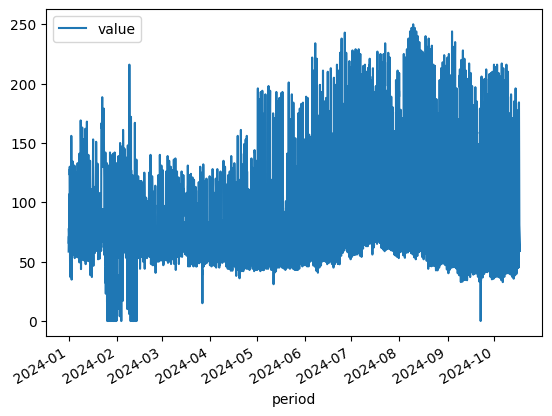

In [18]:
df[df["period"]>"2024"].groupby("subba").plot("period", "value")

In [88]:
df = pd.read_parquet("/Users/pipegalera/dev/Documents/GitHub/energy_forecasting/data/data.parquet")

In [92]:
df["subba-name"].unique()

array(['Pacific Gas and Electric', 'Southern California Edison - CISO',
       'San Diego Gas and Electric - CISO',
       'Valley Electric Association  - CISO'], dtype=object)

In [93]:
df["subba"].unique()

array(['PGAE', 'SCE', 'SDGE', 'VEA'], dtype=object)

In [56]:
test_df = df[df["subba"] == "SCE"]

current_time_utc = datetime.datetime.now(datetime.timezone.utc)
predictions_cutoff_date = current_time_utc - datetime.timedelta(days=3)
test_df["period"] = pd.to_datetime(test_df["period"], utc=True)

/var/folders/t_/mz7djb5j30sfp2hqh5gycx5m0000gn/T/ipykernel_34927/3027311932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["period"] = pd.to_datetime(test_df["period"], utc=True)


In [57]:
test_df["period"]

50729    2019-01-01 01:00:00+00:00
50730    2019-01-01 02:00:00+00:00
50731    2019-01-01 03:00:00+00:00
50732    2019-01-01 04:00:00+00:00
50733    2019-01-01 05:00:00+00:00
                    ...           
101444   2024-10-17 03:00:00+00:00
101445   2024-10-17 04:00:00+00:00
101446   2024-10-17 05:00:00+00:00
101447   2024-10-17 06:00:00+00:00
101448   2024-10-17 07:00:00+00:00
Name: period, Length: 50720, dtype: datetime64[ns, UTC]

In [58]:

test_df[test_df["period"] > predictions_cutoff_date].head(50)

,period,subba,subba-name,parent,parent-name,value,value-units
101400,2024-10-15 05:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12610,megawatthours
101401,2024-10-15 06:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12256,megawatthours
101402,2024-10-15 07:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11671,megawatthours
101403,2024-10-15 09:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10672,megawatthours
101404,2024-10-15 10:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10385,megawatthours
101405,2024-10-15 11:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10120,megawatthours
101406,2024-10-15 12:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10017,megawatthours
101407,2024-10-15 13:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9893,megawatthours
101408,2024-10-15 14:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10262,megawatthours
101409,2024-10-15 15:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11105,megawatthours


In [61]:
test_df.head(50)

,period,subba,subba-name,parent,parent-name,value,value-units
50729,2019-01-01 01:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11039,megawatthours
50730,2019-01-01 02:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12229,megawatthours
50731,2019-01-01 03:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12242,megawatthours
50732,2019-01-01 04:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11937,megawatthours
50733,2019-01-01 05:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11626,megawatthours
50734,2019-01-01 06:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11231,megawatthours
50735,2019-01-01 07:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10741,megawatthours
50736,2019-01-01 08:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10291,megawatthours
50737,2019-01-01 09:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9932,megawatthours
50738,2019-01-01 10:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9609,megawatthours


In [80]:
test_df[test_df["period"] < "2024-10-06"].tail(20)

,period,subba,subba-name,parent,parent-name,value,value-units
101164,2024-10-05 04:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,16061,megawatthours
101165,2024-10-05 05:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,15191,megawatthours
101166,2024-10-05 06:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,14616,megawatthours
101167,2024-10-05 07:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,13757,megawatthours
101168,2024-10-05 08:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,13090,megawatthours
101169,2024-10-05 09:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12061,megawatthours
101170,2024-10-05 10:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11517,megawatthours
101171,2024-10-05 11:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10902,megawatthours
101172,2024-10-05 12:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10386,megawatthours
101173,2024-10-05 13:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10275,megawatthours


In [82]:
#df[df["period"] < "2024-10-06"].to_parquet("/Users/pipegalera/dev/Documents/GitHub/energy_forecasting/data/data.parquet", index=False)

In [83]:
df = pd.read_parquet("/Users/pipegalera/dev/Documents/GitHub/energy_forecasting/data/data.parquet")


In [84]:
test_df = df[df["subba"] == "SCE"]

In [87]:
test_df[test_df["period"] < "2024-10-15"].tail(20)

,period,subba,subba-name,parent,parent-name,value,value-units
101387,2024-10-14 04:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,12019,megawatthours
101388,2024-10-14 05:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11713,megawatthours
101389,2024-10-14 06:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,11489,megawatthours
101390,2024-10-14 07:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10903,megawatthours
101391,2024-10-14 08:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10579,megawatthours
101392,2024-10-14 09:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10199,megawatthours
101393,2024-10-14 10:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,10107,megawatthours
101394,2024-10-14 11:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9815,megawatthours
101395,2024-10-14 12:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9489,megawatthours
101396,2024-10-14 13:00:00+00:00,SCE,Southern California Edison - CISO,CISO,California Independent System Operator,9721,megawatthours
